# Building a linear model for a non-linear problem

## 1. Import libraries


In [1]:
import torch
import torch.nn as nn

import pandas as pd
import matplotlib.pyplot as plt

from torchinfo import summary
from torcheval.metrics.functional import binary_accuracy, binary_confusion_matrix

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix

from helper_functions import plot_decision_boundary, plot_loss_curves
from tqdm.auto import tqdm

%load_ext autoreload
%autoreload 2

## 2. Create data


### 2.1 Creating dataset of circles

In [4]:
NUM_SAMPLES = 1000
RANDOM_SEED = 42

X_array, y_array = make_circles(
    n_samples=NUM_SAMPLES,
    noise=0.03,
    random_state=RANDOM_SEED,
)

print(f"X shape: {X_array.shape}")
print(f"y shape: {y_array.shape}")
print(f"\nFirst 5 samples od X:\n {X_array[:5]}")
print(f"\nFirst 5 samples od y:\n {y_array[:5]}")

X shape: (1000, 2)
y shape: (1000,)

First 5 samples od X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 samples od y:
 [1 1 1 1 0]


### 2.2 Plot the dataset

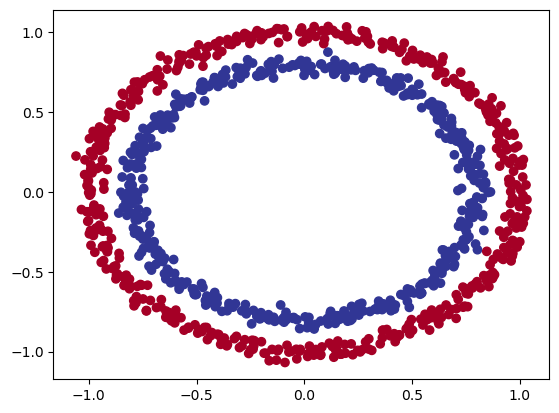

In [3]:
circles = pd.DataFrame({"X1": X_array[:, 0], "X2": X_array[:, 1], "label": y_array})
plt.scatter(x=X_array[:, 0], y=X_array[:, 1], c=y_array, cmap=plt.cm.RdYlBu);

### 2.3 Convert numpy array to torch tensor


In [4]:
X = torch.from_numpy(X_array).type(torch.float)
y = torch.from_numpy(y_array).type(torch.float) # must be float, not integer

print(f"X dtype: {X.dtype}, X shape: {X.shape}")
print(f"y dtype: {y.dtype}, X shape: {y.shape}")

X dtype: torch.float32, X shape: torch.Size([1000, 2])
y dtype: torch.float32, X shape: torch.Size([1000])


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test : {X_test.shape}")
print(f"X_test : {y_test.shape}")

X_train: torch.Size([800, 2])
y_train: torch.Size([800])
X_test : torch.Size([200, 2])
X_test : torch.Size([200])


## 3. Building a binary-class classification model in PyTorch

### 3.1 Creating the model


In [5]:
class CircleModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer_stack(x)

In [6]:
torch.manual_seed(RANDOM_SEED)

model = CircleModel(input_features=2, output_features=1, hidden_units=10)
model

CircleModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [7]:
summary(
    model,
    input_size=(2,),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    row_settings=["var_names"],
)

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
CircleModel (CircleModel)                [2]                       [1]                       --                        True
├─Sequential (linear_layer_stack)        [2]                       [1]                       --                        True
│    └─Linear (0)                        [2]                       [10]                      30                        True
│    └─Linear (1)                        [10]                      [10]                      110                       True
│    └─Linear (2)                        [10]                      [1]                       11                        True
Total params: 151
Trainable params: 151
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### 3.2. Creating a loss function and optimizer

In [8]:
# Create a loss function
# loss_fn = nn.BCELoss()          # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss = sigmoid built-in
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

### 3.3 Getting prediction probabilities for a multi-class PyTorch model

In [9]:
model.eval()
with torch.inference_mode():
    untrained_logits = model(X_test)

print(f"untrained logits shape: {untrained_logits.shape}")
print(f"first 5 untrained logits:\n{untrained_logits[:5]}")

untrained_preds = torch.sigmoid(untrained_logits)
print(f"\nuntrained preds shape: {untrained_preds.shape}")
print(f"first 5 untrained preds:\n{untrained_preds[:5]}")

untrained_classes = torch.round(untrained_preds)
print(f"\nfirst 5 untrained_classes:\n{untrained_classes.squeeze()[:5]}")
print(f"\nfirst 5 labels:\n{y_test[:5]}")

untrained logits shape: torch.Size([200, 1])
first 5 untrained logits:
tensor([[ 0.0559],
        [ 0.0161],
        [ 0.0904],
        [ 0.0463],
        [-0.0200]])

untrained preds shape: torch.Size([200, 1])
first 5 untrained preds:
tensor([[0.5140],
        [0.5040],
        [0.5226],
        [0.5116],
        [0.4950]])

first 5 untrained_classes:
tensor([1., 1., 1., 1., 0.])

first 5 labels:
tensor([1., 0., 1., 0., 1.])


## 4. Train and test the model

### 4.1 training loop

In [10]:
def train(
    epochs: int,
    model: torch.nn.Module,
    X_train: torch.Tensor,
    X_test: torch.Tensor,
    y_train: torch.Tensor,
    y_test: torch.Tensor,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    print_step: int = 10,
) -> dict[str, list]:

    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in tqdm(range(1, epochs + 1)):

        model.train()

        y_logits = model(X_train).squeeze() # must be squeezed

        loss = loss_fn(y_logits, y_train)
        train_loss = loss.item()
        ## Using nn.BCELoss you need torch.sigmoid()
        # loss = loss_fn(torch.sigmoid(y_logits), y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = torch.round(torch.sigmoid(y_logits))
        train_acc = binary_accuracy(y_pred, y_train)

        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test).squeeze()
            test_loss = loss_fn(test_logits, y_test)

            test_pred = torch.round(torch.sigmoid(test_logits))
            test_acc = binary_accuracy(test_pred, y_test)

        if (epoch % print_step == 0) or (epoch == epochs):
            tqdm.write(
                f"Epoch: {epoch:3} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_acc: {train_acc:.4f} | "
                f"test_loss: {test_loss:.4f} | "
                f"test_acc: {test_acc:.4f}"
            )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [11]:
results = train(
    epochs=3000,
    model=model,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    optimizer=optimizer,
    loss_fn=loss_fn,
    print_step=100,
)

  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 100 | train_loss: 0.6930 | train_acc: 0.5063 | test_loss: 0.6938 | test_acc: 0.4900
Epoch: 200 | train_loss: 0.6930 | train_acc: 0.5113 | test_loss: 0.6944 | test_acc: 0.4600
Epoch: 300 | train_loss: 0.6930 | train_acc: 0.5163 | test_loss: 0.6946 | test_acc: 0.4500
Epoch: 400 | train_loss: 0.6930 | train_acc: 0.5113 | test_loss: 0.6946 | test_acc: 0.4600
Epoch: 500 | train_loss: 0.6930 | train_acc: 0.5100 | test_loss: 0.6947 | test_acc: 0.4600
Epoch: 600 | train_loss: 0.6930 | train_acc: 0.5100 | test_loss: 0.6947 | test_acc: 0.4600
Epoch: 700 | train_loss: 0.6930 | train_acc: 0.5100 | test_loss: 0.6947 | test_acc: 0.4600
Epoch: 800 | train_loss: 0.6930 | train_acc: 0.5100 | test_loss: 0.6947 | test_acc: 0.4600
Epoch: 900 | train_loss: 0.6930 | train_acc: 0.5100 | test_loss: 0.6947 | test_acc: 0.4600
Epoch: 1000 | train_loss: 0.6930 | train_acc: 0.5100 | test_loss: 0.6947 | test_acc: 0.4600
Epoch: 1100 | train_loss: 0.6930 | train_acc: 0.5100 | test_loss: 0.6947 | test_acc: 0.46

### 4.2 Plot loss and accuracy curves

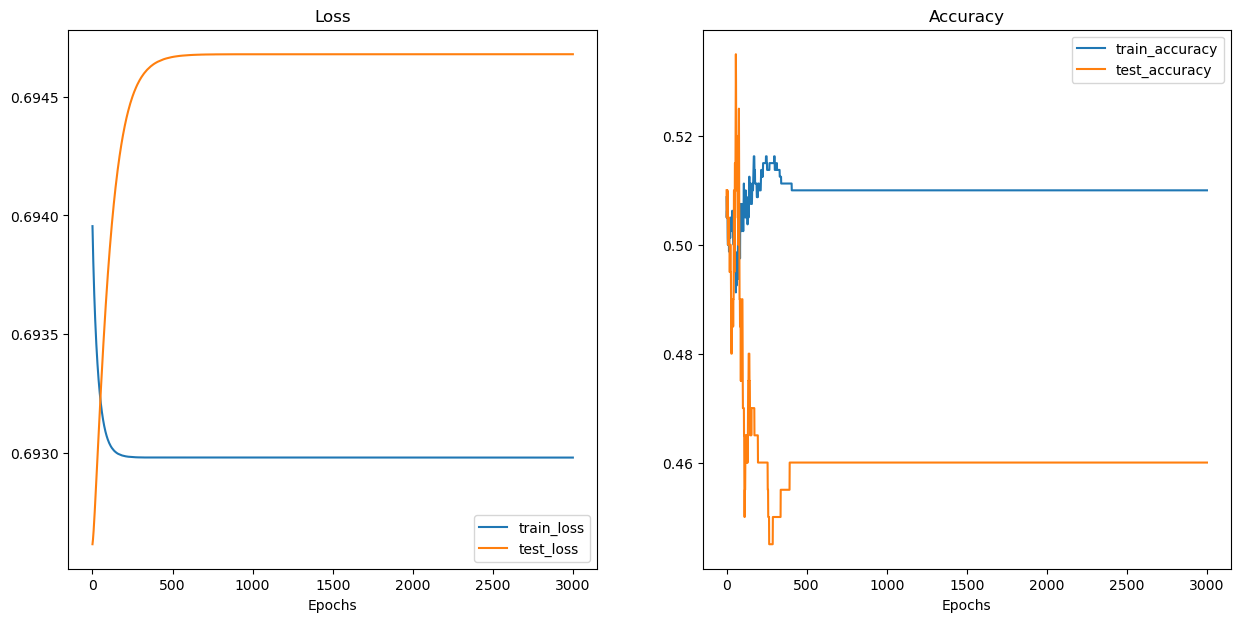

In [12]:
plot_loss_curves(results)

### 4.3 Plot the bounbaries

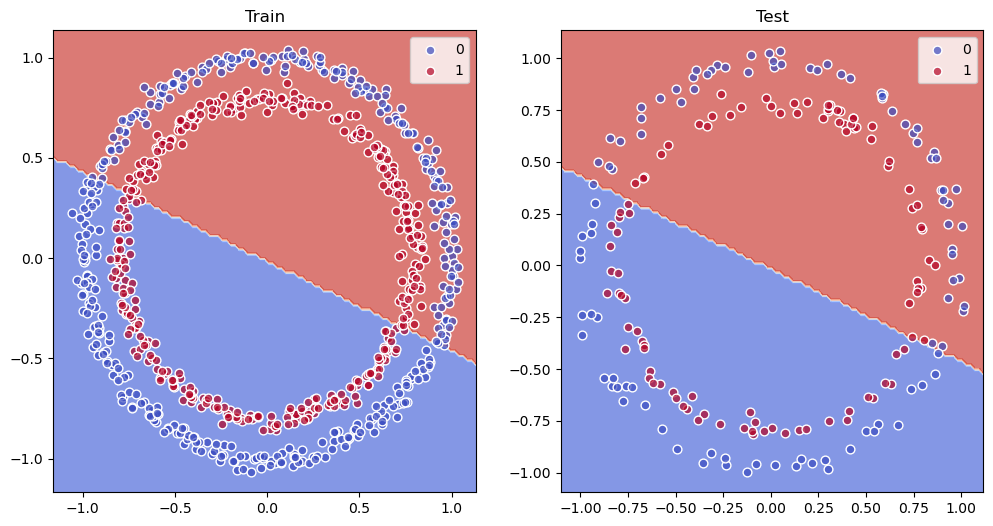

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

### 4.4 Making and evaluating predictions

In [14]:
model.eval()
with torch.inference_mode():
    y_pred_probs_test = model(X_test).squeeze()
    y_pred_test = torch.round(torch.sigmoid(y_pred_probs_test))
    test_loss = loss_fn(y_pred_probs_test, y_test)
    test_acc = binary_accuracy(y_pred_test, y_test)

print(f"First 10 predictions : {y_pred_test[:10]}")
print(f"First 10 labels      : {y_test[:10]}")
print(f"Test accuracy        : {test_acc:.3f}")

First 10 predictions : tensor([1., 1., 0., 1., 0., 0., 1., 1., 0., 1.])
First 10 labels      : tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])
Test accuracy        : 0.460


### 4.5 Plot confusion matrix

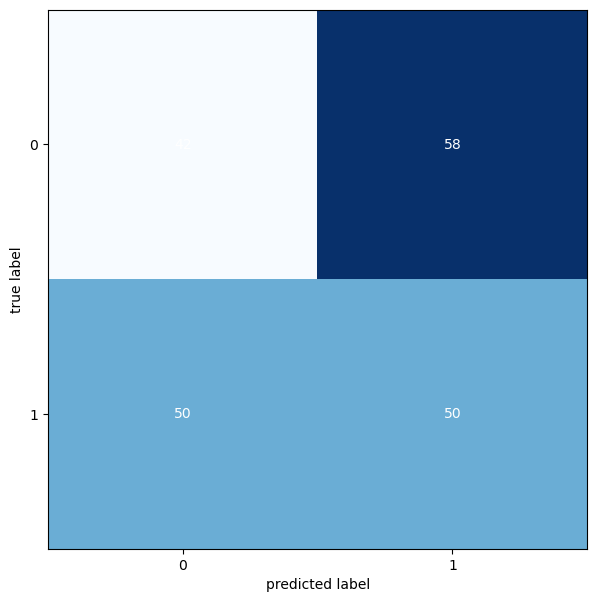

In [15]:
cm = binary_confusion_matrix(y_pred_test, y_test.type(torch.int64)) # must be int64, not float
fig, ax = plot_confusion_matrix(cm.numpy(), figsize=(10, 7))